In [25]:
!pip install -U langchain-nomic langchain_community tiktoken langchainhub langchain langgraph tavily-python
!pip install chromadb==0.4.0
!pip install langchain-nomic
!pip install -U onnxruntime
!pip install pysqlite3
!pip install gpt4all

# Local RAG agent with LLaMA3

- We utilize below 3 advanced RAG techniques to improve the performance of the agent:
    - **Routing: Adaptive RAG** -> Route questions to different retrieval approaches
    - **Fallback: Corrective RAG** -> Fallback to web search if docs are not relevant to query
    - **Self-correction: Self-RAG** -> Fix answers w/ hallucinations or don’t address question

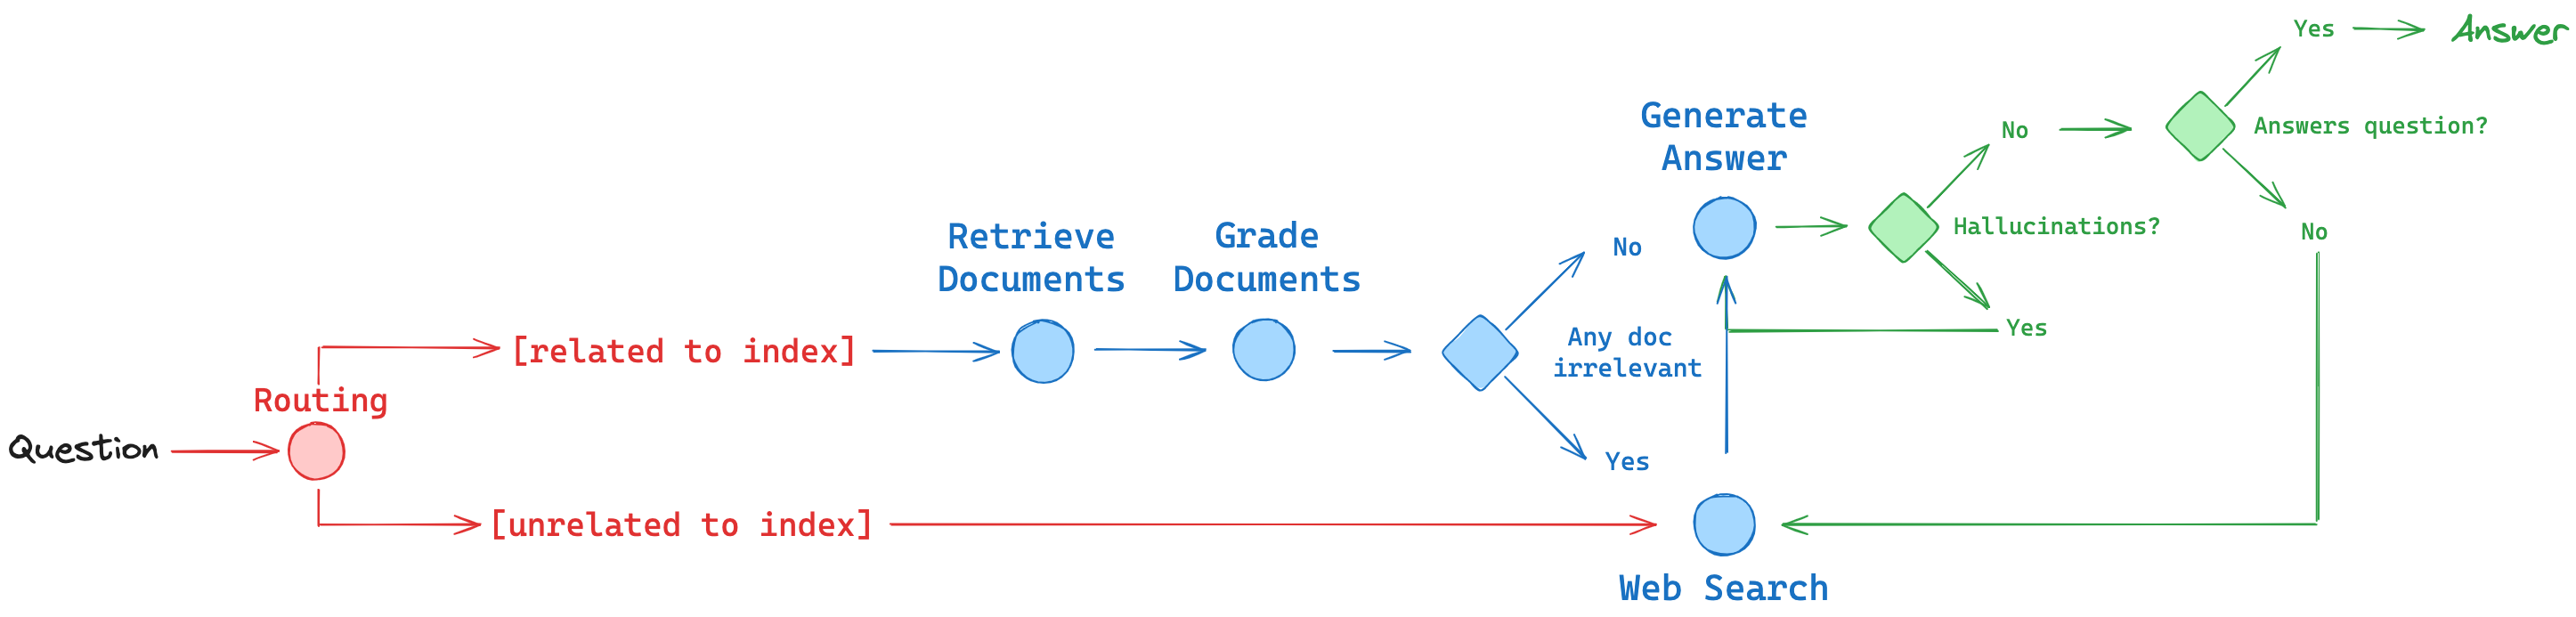

In [57]:
__import__('pysqlite3')
import sys, pysqlite3, os, yaml
sys.modules['sqlite3'] = sys.modules["pysqlite3"]

from typing import List
from langchain import hub
from pprint import pprint
from langchain.schema import Document
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults

In [27]:
urls = [
        "https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
        "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
        ]

In [28]:
# load yaml file
with open("secrets.yaml", "r") as file:
    secrets = yaml.safe_load(file)

os.environ["TAVILY_API_KEY"] = secrets["TAVILY_API_KEY"]

### 1. Configure LLMs

In [29]:
model_dict = {
            "embedding" : GPT4AllEmbeddings(),
            "json_llm" : ChatOllama(
                                    model='llama3', 
                                    format="json", 
                                    temperature=0
                                    ),
            "comp_llm" : ChatOllama(
                                    model='llama3', 
                                    temperature=0
                                    ),
            }

web_search_tool = TavilySearchResults(k=3)

### 2. Load and Process Data

In [30]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
                                                                    chunk_size=250, 
                                                                    chunk_overlap=0
                                                                    )
doc_splits = text_splitter.split_documents(docs_list)

### 3. Retriever

In [31]:
vectorstore = Chroma.from_documents(
                                    documents=doc_splits,
                                    collection_name="rag-chroma",
                                    embedding=model_dict["embedding"],
                                    )
retriever = vectorstore.as_retriever()

### 4. Necessary Prompt Templates

In [32]:
#Contextual Compression
retrieval_grader_prompt = PromptTemplate(
                                    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
                                    of a retrieved document to a user question. If the document contains keywords related to the user question, 
                                    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
                                    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
                                    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
                                    <|eot_id|><|start_header_id|>user<|end_header_id|>
                                    Here is the retrieved document: \n\n {document} \n\n
                                    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                    """,
                                    input_variables=["question", "document"],
                                    )

#Response Synthesizer
sysnthesis_prompt = PromptTemplate(
                            template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
                            Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
                            Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
                            Question: {question} 
                            Context: {context} 
                            Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
                            input_variables=["question", "document"],
                            )

#Hallucination Detector
hallucination_prompt = PromptTemplate(
                            template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
                            an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate 
                            whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
                            single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
                            Here are the facts:
                            \n ------- \n
                            {documents} 
                            \n ------- \n
                            Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
                            input_variables=["generation", "documents"],
                            )

#Answer Grader 
answer_grader_prompt = PromptTemplate(
                                template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
                                answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
                                useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
                                <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
                                \n ------- \n
                                {generation} 
                                \n ------- \n
                                Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
                                input_variables=["generation", "question"],
                            )

#Router
router_prompt = PromptTemplate(
                            template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
                            user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents, 
                            prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords 
                            in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' 
                            or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
                            no premable or explaination. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
                            input_variables=["question"],
                            )

### 5. Utility Functions

In [43]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def print_response_data(
                        question,
                        response,
                        documents=None,
                        ):
    response_str = ""
    response_str += f"Question: {question}\n\n"

    if isinstance(response, dict):
        if "score" in response:
            score = response["score"]
            response_str += f"Score: {score}\n\n"

        if "datasource" in response:
            datasource = response["datasource"]
            response_str += f"Datasource: {datasource}\n\n"

    if isinstance(response, str):
        response_str += f"Response: {response}\n\n"

    if documents:
        response_str += f"Documents:\n{format_docs(documents)}\n"
    print(response_str)

### 6. LCEL

In [34]:
retrieval_grader = retrieval_grader_prompt | model_dict["json_llm"] | JsonOutputParser()
rag_chain = sysnthesis_prompt | model_dict["comp_llm"] | StrOutputParser()
hallucination_grader = hallucination_prompt | model_dict["json_llm"] | JsonOutputParser()
answer_grader = answer_grader_prompt | model_dict["json_llm"] | JsonOutputParser()
router = router_prompt | model_dict["json_llm"] | JsonOutputParser()

### 7. Test Individual Inferece

##### a) Retrieval Grader

In [35]:
question = "tell me about agent memory !"

In [36]:
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
response = retrieval_grader.invoke({
                                    "question": question, 
                                    "document": doc_txt
                                    })

In [37]:
print_response_data(question, response, documents=docs)

Question: tell me about agent memory !

Score: yes

Documents:
They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the agent attempted to consult documentation to execute the procedure. 7 out of 11 were rejected and among these 7 rejected cases, 5 happened after a Web search while 2 were rejected based on prompt only.
Generative Agents Simulation#
Generative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.
The design of generative agents combines LLM with memory, planning and reflection mechanisms to enable agents to behave conditioned o

##### b) Response Synthesizer

In [38]:
question = "what is prompt engineering ?"

In [39]:
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})

In [40]:
print_response_data(question, generation)

Question: what is prompt engineering ?

Response: Based on the provided context, Prompt Engineering refers to methods for how to communicate with Large Language Models (LLMs) to steer their behavior for desired outcomes without updating the model weights. It is an empirical science that requires heavy experimentation and heuristics, as the effect of prompt engineering methods can vary a lot among models.




##### c) Hallucination Detector

In [41]:
response = hallucination_grader.invoke({"documents": docs, "generation": generation})
print_response_data(question, response, documents=docs)

Question: what is prompt engineering ?

Score: yes

Documents:
Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.
This post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.
[My personal spicy take] In my opinion, some prompt engineering papers are not worthy 8 pages long, since those tricks can be explained in one or a few sentences and the rest is all about benchmarking. An easy-to-use and shared benchmark infrastructure should be more beneficial to the community. Iterat

##### d) Answer Grader

In [42]:
response = answer_grader.invoke({"question": question,"generation": generation})
print_response_data(question, generation)

Question: what is prompt engineering ?

Response: Based on the provided context, Prompt Engineering refers to methods for how to communicate with Large Language Models (LLMs) to steer their behavior for desired outcomes without updating the model weights. It is an empirical science that requires heavy experimentation and heuristics, as the effect of prompt engineering methods can vary a lot among models.




##### e) Router

In [50]:
question = "llm agent memory"

In [51]:
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
response = router.invoke({"question": question})

In [52]:
print_response_data(question, response)

Question: llm agent memory

Datasource: vectorstore




### 8. Build Graph

In [67]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    documents = retriever.invoke(question) # Retrieval
    return {
            "documents": documents, 
            "question": question
            }

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    try:
        grade = score['score']
    except:
        grade = "yes"

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [68]:
workflow = StateGraph(GraphState)
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

workflow.set_conditional_entry_point(
                                    route_question,
                                    {
                                        "websearch": "websearch",
                                        "vectorstore": "retrieve",
                                    },
                                    )

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
                            "grade_documents",
                            decide_to_generate,
                            {
                                "websearch": "websearch",
                                "generate": "generate",
                            },
                            )

workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
                            "generate",
                            grade_generation_v_documents_and_question,
                            {
                                "not supported": "generate",
                                "useful": END,
                                "not useful": "websearch",
                            },
                            )
app = workflow.compile()

In [69]:
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What are the types of agent memory?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('The types of agent memory mentioned in the context are:\n'
 '\n'
 '* Sensory Memory\n'
 '* Iconic Memory (visual)\n'
 '* Echoic Memory (auditory)\n'
 '* Haptic Memory (touch)\n'
 '\n'
 'These types of memory are used to acquire, store, retain, and later retrieve '
 'information.')


In [70]:
inputs = {"question": "Who is Virat Kohli?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Who is Virat Kohli?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
("It seems like you're asking me to summarize the text about Virat Kohli's "
 "cricket career. Here's my attempt:\n"
 '\n'
 'Virat Kohli is an Indian cricketer who has had a successful career in '
 'various formats of the game, including Test matches, One-Day Internationals '
 '(ODIs), and Twenty20 Internationals (T20Is). He made his international debut '
 'in 2008 and quickly established himself as a talented batsman. Kohli has '
 'scored numerous centuries and has been named the International Cricket '
 "Council's (ICC) Player of the Year.\n"
 '\n'
 "The text highlights some of Kohli's notable performances, including his 